# Week 5: making sense of lots of data: PCA, clustering
In week four we talked about making sense of data that was tree like-- i.e. biological sequences that derive from common ancestors. In this week we will try to generalize our approaches to clustering data and talk about Principle Component Analysis as a key tool for visualization and dimensionality reduction for biological datasets.

## Principle Component Analysis
Principle Component Analysis or PCA, was introduced by Karl Pearson in 1901 as a way to transform a dataset in $m$ dimensions into a new coordinate system. This coordinate transform puts the observations (datapoints) into dimensions that are made up of linear combinations (i.e. sums) of the original dimensions, and arranged in such a way that the dimensions explain decreasing amounts of the variation present in the data. Multi-dimensional data that might be appropriate for PCA occur all over the biological world-- for instance the genotype of a individual at many loci, or the level of transcription of a large number of genes for a particular cell. 

One of the huge benefits of this approach is that we can look at fewer dimensions of the data and get a decent approximation of all the variation that is present. This is called _dimensionality reduction_ in the business. There is a trade off between reduction of complexity and information content of course-- reducing dimensionality does lose information-- but the benefits for data exploration are very real. 

In lecture I went through the following [interactive plots](http://setosa.io/ev/principal-component-analysis/) which I really like. Please spend some time messing around there to get a sense of what this transformation does to data.

PCA has been used in many different ways in computational genetics. For instance colleagues of mine were able to show that [human genetic variation largely mirrors patterns of geography in Europe](http://www.nature.com/nature/journal/v456/n7218/fig_tab/nature07331_F1.html). Other examples include [classifying different soft tissue tumors](http://www.sciencedirect.com/science/article/pii/S0140673602082703); [visualizing gene oscillations](http://www.pnas.org/content/103/44/16254.full) and subsequently intuiting [genetic networks](http://www.pnas.org/content/97/15/8409.full); and [removing noise from genetic data](http://www.pnas.org/content/97/18/10101.full).

## `Scikit-learn`
To play with PCA and other clustering algorithms we will use a fantastic python package that is aimed at machine learning (a subset of statistics). 

In [1]:
import sklearn
from sklearn import datasets
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

iris = datasets.load_iris()
df_iris = pd.DataFrame(iris.data,columns=iris.feature_names)
df_iris['species'] = iris.target_names[iris.target]

# Take a look at df_iris
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


We can plot pairwise comparisons using Seaborn's `pairplot()` function to see if there are striking correlations between any two features of the iris data set. If any two features are highly correlated, we may assume we can summarize those two features with a single axis (i.e. "new" feature) that includes both.

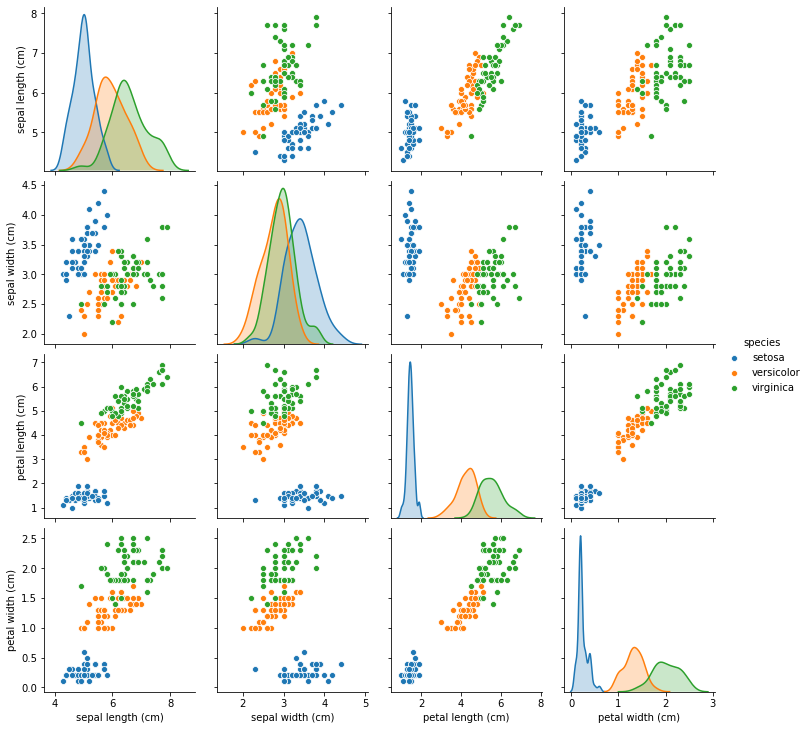

In [2]:
sns.pairplot(df_iris, hue='species')

Right away from this plot we can notice that *versicolor* and *virginica* are more similar to each other than to *setosa*.  There is also a strong correlation between *petal length* and *petal width*. Let's focus on these two parameters to explain how we do PCA.

Let's start by plotting petal length against width. We will add a "marker" for where the means of the two traits are.

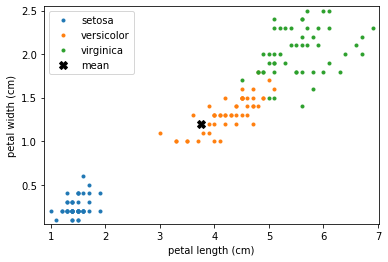

In [3]:
# Compute the mean
m = np.array([df_iris['petal length (cm)'].mean(), 
              df_iris['petal width (cm)'].mean()])

# Plot petal length vs petal width only
for key, group in df_iris.groupby(['species']):
    plt.plot(group['petal length (cm)'], group['petal width (cm)'],
               label=key, marker='.', linestyle='none')

# Add the mean value to the plot
plt.plot(m[0], m[1], marker='X', color='black', markersize=8,
         linestyle='none', label='mean')

plt.legend(loc=0)
plt.margins(0.02)
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)');

# A quick look at the axes of variation
PCA summarizes a dataset by the amount of variation that occurs along each axis, and uses that summary to transform the data into a new coordinate axis. To give you a sense of how this summary works, we will walk through the first steps in class.

We will take the iris data, center it (i.e. make each column mean zero), compute the [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix) of the data, and then compute the [eigenvectors and eigenvalues](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) of that covariance matrix. This procedure amounts to fitting best fit lines along the orthogonal axes that best describe a dataset. 

Okay so let's go through this first bit here. You will do the whole manual proceedure in discussion as well.

1. Center our dataset

In [4]:
# Substract the mean from the measurements.
df_centered = df_iris.loc[:, ['petal length (cm)', 'petal width (cm)']]
for col in df_centered.columns:
    df_centered[col] -= df_centered[col].mean()

2. Compute the covariance matrix of the data, and then get the eigen decomposition of that matrix to get eigenvectors and eigenvalues. 

In [5]:
cov_mat = np.cov(df_centered.transpose())
print('Covariance matrix \n', cov_mat)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors\n', eig_vecs)
print('\nEigenvalues\n', eig_vals)

Covariance matrix 
 [[3.11627785 1.2956094 ]
 [1.2956094  0.58100626]]
Eigenvectors
 [[ 0.92177769 -0.38771882]
 [ 0.38771882  0.92177769]]

Eigenvalues
 [3.66123805 0.03604607]


these eigenvectors tell us the directions of maximal variation within our data and the eigenvalues tell us the magnitudes of those vectors. having computed those we will plot them on to our original plot of petal length vs petal width 

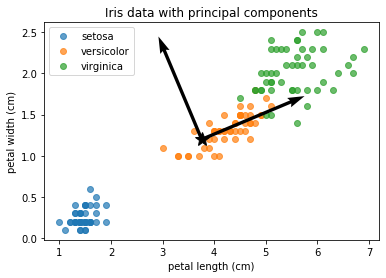

In [6]:
# Plot Petal length vs petal width only
for key, group in df_iris.groupby(['species']):
    plt.plot(group['petal length (cm)'], group['petal width (cm)'],
               label=key, marker='o', linestyle='none', alpha=0.7)

# Add the mean value to the plot
plt.plot(m[0], m[1], marker='*', color='black', markersize=15)

# Add arrows showing the eigenvectors
plt.quiver([m[0]]*2, [m[1]]*2, eig_vecs[:,1], eig_vecs[:,0], zorder=11, 
           width=0.01, scale=3)
    
# Tidy up plot
plt.legend()
#plt.margins(0.02)
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.title('Iris data with principal components');

make sense? see the planes in which those arrows lie? They are describing variation in our 2D data! 

Now there are a bunch of other steps to complete the PCA that we won't cover here but that you will do in discussion section

# Doing PCA the easy way
`scikit-learn` makes doing all this PCA business a snap. Let's go through the very simples steps you would take to do a _full_ PCA analysis on the Iris dataset. We start by looking at how much of the variation is explained by principal components.

In [7]:
from sklearn import decomposition
# Instantiate the PCA object
sklearn_pca = sklearn.decomposition.PCA()

# Pass the data to the fit method
sklearn_pca.fit(df_iris[iris.feature_names])

# Print the variance explained
print('Variance percent explained\n', sklearn_pca.explained_variance_ratio_)

Variance percent explained
 [0.92461872 0.05306648 0.01710261 0.00521218]


We can see that the first component captures 92% of the variability in the data! We can now easily project our 4-D dataset into any $k$ dimensional space we would like. Since we've already seen a 0-D and 1-D reduction, let's look at the data in 2-D space.

In [8]:
# Perform the PCA again retaining only the top 2 components
sklearn_pca = sklearn.decomposition.PCA(n_components=2)
sklearn_pca.fit(df_iris[iris.feature_names])

# Project the data into this 2D space and convert it back to a tidy dataframe
df_2D = pd.DataFrame(sklearn_pca.transform(df_iris[iris.feature_names]),
                     columns=['PCA1', 'PCA2'])

# Create a column for species name
df_2D['species'] = df_iris['species']

# Look at the result
df_2D.head()

,PCA1,PCA2,species
0,-2.684126,0.319397,setosa
1,-2.714142,-0.177001,setosa
2,-2.888991,-0.144949,setosa
3,-2.745343,-0.318299,setosa
4,-2.728717,0.326755,setosa


Now we can plot our original 4-D data onto a 2-D space that retains nearly 93% of the variability.

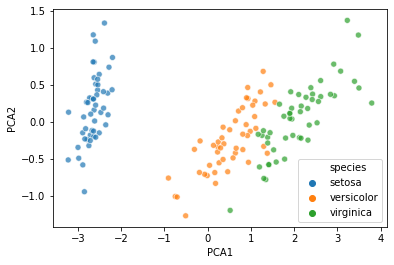

In [9]:
# plot using seaborn again

sns.scatterplot(df_2D.PCA1,df_2D.PCA2,hue=df_2D.species,alpha=0.7)


# PCA on genetic data
You knew I was going here... a great use for PCA is to understand how individuals might cluster, one to another, on the basis of their genotypes at a large number of loci. We will represent individuals as rows in a matrix, where the columns represent SNP genotypes at individual SNPs. Those take the values 0, 1, 2 depending on the number of a particular allele at that locus (normally the so called minor allele, that which is less frequent in the population. One we've made this leap-- from genotype to numerically coded matrix-- we are all set for PCA.

I've included a transformation of the SARS-CoV-2 data that is in a matrix format at `data/gisaid_covid_snps_minor_allele_matrix.txt`. We will use pandas to read that in, and then use something called a _imputation_ routine that will attempt to "fill in" missing data in my matrix. Aside from that, every thing is the same and we can quickly and easily look at clustering

Variance percent explained
 [0.24825248 0.09665092]


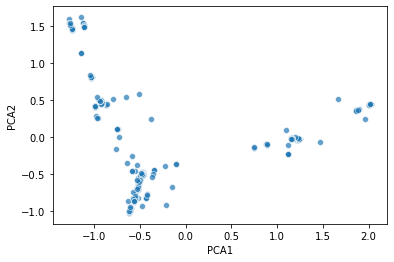

In [10]:
from sklearn.impute import SimpleImputer

snps = pd.read_csv("data/gisaid_covid_snps_minor_allele_matrix.txt","\t")
imp = SimpleImputer()
snps_i = imp.fit_transform(snps.drop('sampleID',axis=1))

# Perform the PCA again retaining only the top 2 components
sklearn_pca = sklearn.decomposition.PCA(n_components=2)
sklearn_pca.fit(snps_i)


# Project the data into this 2D space and convert it back to a tidy dataframe
df_2D = pd.DataFrame(sklearn_pca.transform(snps_i),
                     columns=['PCA1', 'PCA2'])

# Create a column for species name
df_2D['sampleID'] = snps['sampleID']

sns.scatterplot(df_2D.PCA1,df_2D.PCA2,alpha=0.7)
print('Variance percent explained\n', sklearn_pca.explained_variance_ratio_)

## Metadata
So the figure above isn't really that pleasing. We see clusters but we have nothing to relate them too, not even their sample IDs. Let's fix this by bringing in metadata associated with these genotypes.

[Metadata](https://en.wikipedia.org/wiki/Metadata) generally refers to any data that sits alongside a dataset that helps further describe what the numbers correspond to. A lot of attention has been paid to best practices for dealing with metadata over the past few decades and indeed there is a growing awareness that metadata is often a limiting reagent in our ability to make sense of large datasets. 

I've stuffed a whole bunch of metadata about these SARS-CoV-2 genomes in `data/nexstrain_metadata_19mar2020.tsv`, we can open that up and take a look

In [11]:
# get metadata
meta = pd.read_csv("data/nexstrain_metadata_19mar2020.tsv","\t")
meta.head()

,strain,virus,gisaid_epi_isl,genbank_accession,date,region,country,division,division_exposure,location,...,length,host,age,sex,originating_lab,submitting_lab,authors,url,title,date_submitted
0,Anhui/SZ005/2020,ncov,EPI_ISL_413485,?,2020-01-24,Asia,China,Anhui,Anhui,Suzhou,...,29860,Human,58,Male,"Department of microbiology laboratory,Anhui Pr...","Department of microbiology laboratory,Anhui Pr...",Li et al,https://www.gisaid.org,?,2020-03-05
1,Australia/NSW01/2020,ncov,EPI_ISL_407893,?,2020-01-24,Oceania,Australia,New South Wales,Hubei,Sydney,...,29782,Human,43,Male,Centre for Infectious Diseases and Microbiolog...,NSW Health Pathology - Institute of Clinical P...,Eden et al,https://www.gisaid.org,?,2020-02-06
2,Australia/NSW02/2020,ncov,EPI_ISL_408976,?,2020-01-22,Oceania,Australia,New South Wales,New South Wales,Sydney,...,29741,Human,53,Male,Centre for Infectious Diseases and Microbiolog...,NSW Health Pathology - Institute of Clinical P...,Rockett et al,https://www.gisaid.org,?,2020-02-11
3,Australia/NSW03/2020,ncov,EPI_ISL_408977,?,2020-01-25,Oceania,Australia,New South Wales,New South Wales,Sydney,...,29782,Human,21,Female,"Serology, Virology and OTDS Laboratories (SAVi...",NSW Health Pathology - Institute of Clinical P...,Eden et al,https://www.gisaid.org,?,2020-02-11
4,Australia/NSW05/2020,ncov,EPI_ISL_412975,?,2020-02-28,Oceania,Australia,New South Wales,Iran,Sydney,...,29782,Human,43,Male,Centre for Infectious Diseases and Microbiolog...,NSW Health Pathology - Institute of Clinical P...,Eden et al,https://www.gisaid.org,?,2020-03-02


In [12]:
# filter our those individuals not in metadata
filt = snps.sampleID.isin(meta.gisaid_epi_isl)
snps_filt_m = snps[filt]

In [13]:
# make color dict from regions
cdict = {}
current_palette = sns.color_palette()
for i,x in enumerate(meta.region.unique()):
    cdict[x] = current_palette[i]

In [14]:
# associate IDs with regions in dict
bridge = {}
for idx, row in meta.iterrows():
    bridge[row.gisaid_epi_isl] = row.region

In [15]:
samp_regions_cols = []
reg_name = []
keys = bridge.keys()
for idx, row in snps_filt_m.iterrows():
    samp_regions_cols.append(cdict[bridge[row.sampleID]])
    reg_name.append(bridge[row.sampleID])
 
print(samp_regions_cols[0])
    

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)


Variance percent explained
 [0.24763659 0.09758194]


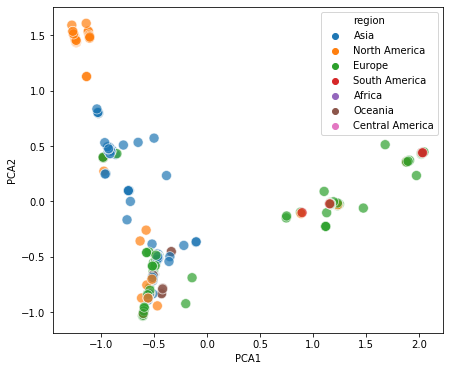

In [16]:
snps_i = imp.fit_transform(snps_filt_m.drop('sampleID',axis=1))

# Perform the PCA again retaining only the top 2 components
sklearn_pca = sklearn.decomposition.PCA(n_components=2)
sklearn_pca.fit(snps_i)


# Project the data into this 2D space and convert it back to a tidy dataframe
df_2D = pd.DataFrame(sklearn_pca.transform(snps_i),
                     columns=['PCA1', 'PCA2'])

# Create a column for species name
df_2D['sampleID'] = snps['sampleID']
df_2D['col'] = samp_regions_cols
df_2D['region'] = reg_name

plt.figure(figsize=(7,6))
sns.scatterplot(df_2D.PCA1,df_2D.PCA2,alpha=0.7, s=100, hue=df_2D.region)
print('Variance percent explained\n', sklearn_pca.explained_variance_ratio_)


# Bokeh for metadata viz
There is an incredible tool for python called `bokeh` which allows us to create interactive visualizations of our data that we can do things with, like mouse over, click, hover, etc.. Rather than focus on more weighty, mathematical material at the end of this week, I'd like to play with bokeh and have some fun. 

Currently, the [documentation for bokeh](https://docs.bokeh.org/en/latest/index.html#) is quite good, if not a bit intimidating in its thoroughness. This tool is worth your reading about and exploring for fun, so I'd encourage you guys to go through the [quickstart material](https://docs.bokeh.org/en/latest/docs/user_guide/quickstart.html) although we will cover some subset of it here.

# bokeh creates interaction
bokeh allows us to quickly and easily create **interactive** visual displays of data that we can play with in a web browser. It does it's magic by running a server in the background, sending commands to this server using a different programming language (javascript) automatically, as you hover or click over elements of plots. For some purposes one needs to mess with the server itself, for instance to create fully contained applications that you could ship to users. For _our_ purposes however will will ignore the server altogether and pretend that it doesn't exist.

We will interact with bokeh via the `bokeh.plotting` module which allows for simple, intuitive interactive plots. So a very simple example would look like the following

In [17]:
import bokeh
from bokeh import models, plotting, io

# prepare some data
x = [1, 2, 3, 4, 5]
y = [6, 7, 2, 4, 5]

# output to static HTML file
#output_file("lines.html")

# output to notebook only
bokeh.io.output_notebook()

# create a new plot with a title and axis labels
p = plotting.figure(title="simple line example", x_axis_label='x', y_axis_label='y')

# add a line renderer with legend and line thickness
p.line(x, y, legend_label="Temp.", line_width=2)

# show the results
bokeh.io.show(p)


Loading BokehJS ...

the basic steps here were to
1. define some data
2. tell `bokeh` where to output. In this case we used `output_notebook()` but there is also a `output_file()` command that will store the output as an html file you can play with!
3. call `figure()` -- this sets up our interactive palette that we can draw on and is quite similar conceptually to the more familiar `matplot.pyplot.figure()`
4. add what are called **renderers** - these are the way data is drawn on the plot. For the figure above we simply used `line` elements but there are a whole variety of so-called ["glyphs" to check out](https://docs.bokeh.org/en/latest/docs/user_guide/plotting.html)
5. call `show()` or `save()` to get our plots


let's look a more sophisticated example

In [18]:
import numpy as np

# prepare some data
N = 4000
x = np.random.normal(size=N) * 20
y = np.random.normal(size=N) * 20

radii = np.random.random(size=N) * 1.5

colors = [
    "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)
]

# output to static HTML file (with CDN resources)
#output_file("color_scatter.html", title="color_scatter.py example", mode="cdn")

# I can define what tools i want to show up!import numpy as np

TOOLS = "crosshair,pan,wheel_zoom,box_zoom,reset,box_select,lasso_select"

# create a new plot with the tools above, and explicit ranges
p = plotting.figure(tools=TOOLS, x_range=(-100, 100), y_range=(-100, 100))
x
# add a circle renderer with vectorized colors and sizes
p.circle(x, y, radius=radii, fill_color=colors, fill_alpha=0.6, line_color=None)

# show the results
plotting.show(p)

## Linked panning

Linked panning (when multiple plots have ranges that stay in sync) is simple to spell with Bokeh. You simply share the appropriate range objects between two (or more) plots. The example below shows how to accomplish this by linking the ranges of three plots in various ways:

In [19]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()
from bokeh.layouts import gridplot

x = list(range(11))
y0, y1, y2 = x, [10-i for i in x], [abs(i-5) for i in x]

plot_options = dict(width=250, plot_height=250, tools='pan,wheel_zoom')

# create a new plot
s1 = figure(**plot_options)
s1.circle(x, y0, size=10, color="navy")

# create a new plot and share both ranges
s2 = figure(x_range=s1.x_range, y_range=s1.y_range, **plot_options)
s2.triangle(x, y1, size=10, color="firebrick")

# create a new plot and share only one range
s3 = figure(x_range=s1.x_range, **plot_options)
s3.square(x, y2, size=10, color="olive")

p = gridplot([[s1, s2, s3]])

# show the results
show(p)

Loading BokehJS ...

# Hover Tools

Bokeh has a Hover Tool that allows additional information to be displayed in a popup whenever the user hovers over a specific glyph. Basic hover tool configuration amounts to providing a list of ``(name, format)`` tuples. The full details can be found in the User's Guide [here](https://bokeh.pydata.org/en/latest/docs/user_guide/tools.html#hovertool).

The example below shows some basic usage of the Hover tool with a circle glyph, using hover information defined in utils.py:

In [20]:
from bokeh.models import HoverTool
from bokeh.models import ColumnDataSource

source = ColumnDataSource(
        data=dict(
            x=[1, 2, 3, 4, 5],
            y=[2, 5, 8, 2, 7],
            desc=['A', 'b', 'C', 'd', 'E'],
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = plotting.figure(plot_width=300, plot_height=300, tools=[hover], title="Mouse over the dots")

p.circle('x', 'y', size=20, source=source)

show(p)

I'll introduce the library using some canned examples and then we will turn to annotating the PCA plot for SARS-CoV-2 variation above to make it interactive.

In [22]:
import bokeh
from bokeh import models, plotting, io


bokeh.io.output_notebook()
# What pops up on hover?
tooltips = [('region', '@region'),
            ('ID', '@sampleID')]

# these does color transformation from above
# see cdict 
rbg_dict = {}
for i, (k, v) in enumerate(cdict.items()):
    rbg_dict[k] = tuple([x * 255 for x in v])
rbg_dict



# Make the hover tool
hover = bokeh.models.HoverTool(tooltips=tooltips)

# Create figure
p = bokeh.plotting.figure(plot_width=650, plot_height=450, x_axis_label='PC1',
                          y_axis_label='PC2')

# Add the hover tool
p.add_tools(hover)



for key, group in df_2D.groupby('region'):
    # Specify data source
    source = bokeh.models.ColumnDataSource(group)
    print(cdict[key])
    p.circle(x='PCA1', y='PCA2', size=7, alpha=0.7, source=source,
                 color=rbg_dict[key],
                 legend_label=key)

p.legend.background_fill_alpha = 0.25
p.legend.background_fill_color = 'blanchedalmond'
bokeh.io.show(p)


Loading BokehJS ...

(0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
(0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
(0.5803921568627451, 0.403921568627451, 0.7411764705882353)
(1.0, 0.4980392156862745, 0.054901960784313725)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)


### Acknowledgements
This document uses materials released under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/) as will this document be. 